# Прототип модели для определения рыночной стоимости автомобиля

______________
Задача:

- построить модель для определения стоимости автомобиля для пользователей сервиса по продаже автомобилей с пробегом «Не бит, не крашен». 
_____________

______

#### Данное исследование разделим на несколько частей.
______________________
### Часть 1: Подготовка данных
* [1. Изучение файла с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Предобработка данных.](#2-bullet)

### Часть 2: Обучение моделей
* [1. Обучение моделей и поиск лучших на основе метрики RMSE.](#3-bullet)

### Часть 3: Анализ моделей
* [1. Анализ времени работы моделей и их качества.](#4-bullet)
____________________

#### Описание данных:¶

Признаки:

- DateCrawled — дата скачивания анкеты из базы.
- VehicleType — тип автомобильного кузова.
- RegistrationYear — год регистрации автомобиля.
- Gearbox — тип коробки передач.
- Power — мощность (л. с.).
- Model — модель автомобиля.
- Kilometer — пробег (км).
- RegistrationMonth — месяц регистрации автомобиля.
- FuelType — тип топлива.
- Brand — марка автомобиля.
- NotRepaired — была машина в ремонте или нет.
- DateCreated — дата создания анкеты.
- NumberOfPictures — количество фотографий автомобиля.
- PostalCode — почтовый индекс владельца анкеты (пользователя).
- LastSeen — дата последней активности пользователя.

Целевой признак:

- Price — цена (евро)

#### 1-bullet 
#### Часть 1: Подготовка данных
1. Изучение файла с данными, получение общей информации, загрузка библиотек.

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import time
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot as plt

In [2]:
# прочитаем файл и получим общие данные,
# количество дубликатов и первые пять строк
df = pd.read_csv('/datasets/autos.csv')
display(df.info())
print('Количество дубликатов:', df.duplicated().sum())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

Количество дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


- получили датасет, состоящий из 16 столбцов и 354369 строк. 
- в таблице содежражтся разные типы данных.
- в некоторых стоблцах имеются пропуски, а также имеется 4 дубликата.

#### 2-bullet
#### Часть 1: Подготовка данных
2. Предобработка данных.

In [3]:
# удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

# заполним пропуски в стоблцах 'VehicleType', 
# 'FuelType', 'NotRepaired' на 'неизвестно',
# поскольку из невозможно восстановить
col_list_nan = ['VehicleType', 'FuelType', 'NotRepaired']
for i in col_list_nan:
    df[i] = df[i].fillna('unknown')

# удалим строки, где есть пустующие значения,
# т.к. их количество мальенькое по сравнению с общим
df = df.dropna().reset_index(drop=True) 

# приведем дату и время к общему формату
col_list_date = ['DateCrawled', 'DateCreated', 'LastSeen'] 
for i in col_list_date:
    df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S')
    
# выведем на экран общую информацию
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318958 entries, 0 to 318957
Data columns (total 16 columns):
DateCrawled          318958 non-null datetime64[ns]
Price                318958 non-null int64
VehicleType          318958 non-null object
RegistrationYear     318958 non-null int64
Gearbox              318958 non-null object
Power                318958 non-null int64
Model                318958 non-null object
Kilometer            318958 non-null int64
RegistrationMonth    318958 non-null int64
FuelType             318958 non-null object
Brand                318958 non-null object
NotRepaired          318958 non-null object
DateCreated          318958 non-null datetime64[ns]
NumberOfPictures     318958 non-null int64
PostalCode           318958 non-null int64
LastSeen             318958 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 38.9+ MB


None

In [4]:
# посмотрим уникальные значения и их количество
# в нечисловых столбцах
col_list_unique = ['VehicleType', 'Gearbox', 
                   'Model', 'FuelType', 'Brand', 
                   'NotRepaired']
for i in col_list_unique:
    print(df[i].value_counts())

sedan          85937
small          73613
wagon          61435
bus            27081
unknown        23704
convertible    18722
coupe          14849
suv            10959
other           2658
Name: VehicleType, dtype: int64
manual    255922
auto       63036
Name: Gearbox, dtype: int64
golf                  27757
other                 23024
3er                   19086
polo                  12334
corsa                 11791
                      ...  
i3                        7
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64
petrol      200922
gasoline     92546
unknown      19734
lpg           4854
cng            531
hybrid         203
other          108
electric        60
Name: FuelType, dtype: int64
volkswagen       69566
opel             36098
bmw              33868
mercedes_benz    29739
audi             27081
ford             22945
renault          16207
peugeot           9751
fiat 

- одних и тех же значений, записанных разными/похожими словами не обнаружили.
- стемминг/лемматизация не требуется. 

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,318958.000000,318958.000000,318958.000000,318958.000000,318958.000000,318958.0,318958.000000
mean,4608.905502,2003.427031,114.965265,128844.738179,5.908107,0.0,50766.394149
std,4564.241216,30.517461,185.627579,36620.680186,3.634281,0.0,25780.246706
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30455.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.000000
75%,6700.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71357.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


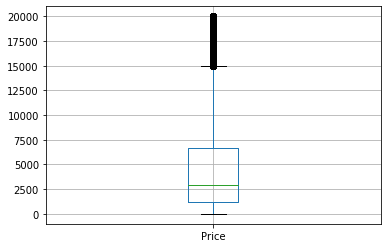

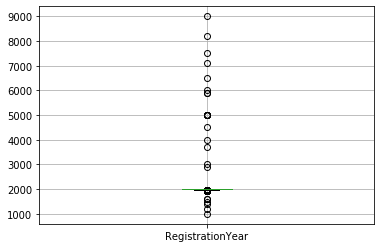

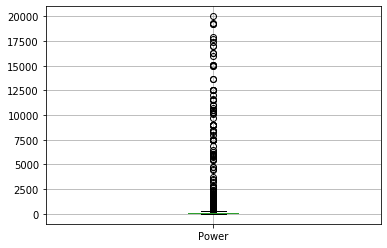

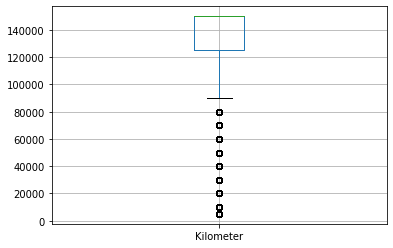

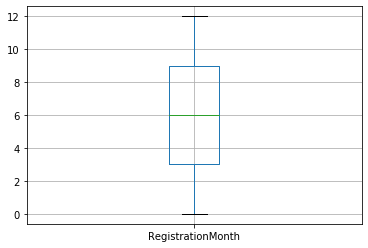

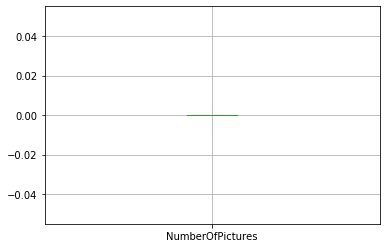

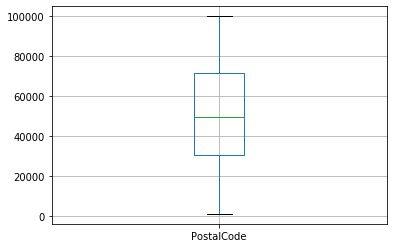

In [5]:
# посмотрим статистическу информацию
display(df.describe())

# посмотрим наличие выбросов в численных данных
# с помощью диаграммы размаха
col_list_outliers = ['Price', 'RegistrationYear', 
                     'Power', 'Kilometer', 'RegistrationMonth', 
                     'NumberOfPictures', 'PostalCode']

for i in col_list_outliers:
    df.boxplot(i) 
    plt.show()

- в столбце Price минимальное нулевое значение
- в столбце RegistrationYear минимальное значение года - 1000, а максимальное - 9000. Очевидно здесь выбросы. Нужно будет избавиться от них, выбрав диапазон.
- в столбце Power минимальное значение 20000 л.с тоже является выбросом. Я дума, максимальная мощность не более 2000 л.с. поэтому здесь тоже нужно будет избавиться от таких значений.
- в столбце NumberOfPictures вообще все данные нулевые и никакой нагрузки не несут, будут только мешать, поэтому удалим этот столбцев вообще.
- остальные столбцы годятся.

In [6]:
# удалим столбецы NumberOfPictures, PostalCode и
# столбцы с времением 'DateCrawled', 'DateCreated', 'LastSeen'
# т.к. не умею с ними работать
df = df.drop(columns = ['NumberOfPictures', 'DateCrawled', 
                        'DateCreated', 'LastSeen', 'PostalCode'])

# удалим выбросы
df = df.query('1970<=RegistrationYear<=2016 and 0<Power<=2000')

# посмотрим статистическу информацию
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,285703.000000,285703.000000,285703.00000,285703.000000,285703.000000
mean,4829.103832,2002.943879,121.79346,128493.908009,6.031141
std,4630.333665,6.147512,62.46829,36526.568538,3.568974
min,0.000000,1970.000000,1.00000,5000.000000,0.000000
25%,1300.000000,1999.000000,78.00000,125000.000000,3.000000
50%,3150.000000,2003.000000,113.00000,150000.000000,6.000000
75%,6999.000000,2007.000000,150.00000,150000.000000,9.000000
max,20000.000000,2016.000000,2000.00000,150000.000000,12.000000


- теперь данные готовы для работы. приступим к следующему этапу.

#### 3-bullet
#### Часть 2: Обучение моделей
1. Обучение моделей и поиск лучших на основе метрики RMSE.

In [7]:
# преобразуем данные техникой OHE
df_ohe = pd.get_dummies(df, drop_first=True)

# получим и сохраним признаки и целевой признак
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

# сохраним значение параметра random_state в переменной
my_random_state = 123

# разделим на две выборки: на тестовую и для обучения с валидацией
f_train_valid, f_test, t_train_valid, t_test = (
            train_test_split(features, target, test_size=0.20, 
                             random_state=my_random_state))

# разделим на две выборки обучающую с валидационной выборку
f_train, f_valid, t_train, t_valid = (
            train_test_split(f_train_valid, t_train_valid, 
                             test_size=0.25,
                             random_state=my_random_state))

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# создадим спискок численных признаков, подлежащих стандартизации   
numeric = ['RegistrationYear', 'Power', 
           'Kilometer', 'RegistrationMonth']

# создадим список выборок подлежащих масштабированию
scaler_list = [f_train_valid, f_test,  
               f_train, f_valid]

# создадим цикл
for i in scaler_list:
    # вызовем преобразователь масштаба и настоим его на признаках
    scaler = StandardScaler()
    scaler.fit(i.loc[:, numeric]) 

    # преобразуем признаки
    i.loc[:, numeric] = scaler.transform(i.loc[:, numeric])

- далее найдем оптимальные гиперпараметры моделей, ориентируясь на метрику RMSE.

обучим модель линейная регрессия и найдем значение метрики RMSE.

In [9]:
model = LinearRegression(normalize=True)
model.fit(f_train, t_train) # обучите модель на тренировочной выборке
predictions_valid = model.predict(f_valid) # получите предсказания модели на валидационной выборке

result = mean_squared_error(t_valid, predictions_valid) ** 0.5# посчитайте значение метрики RMSE на валидационной выборке
print("RMSE модели линейной регрессии на валидационной выборке: %.2f" % result)

RMSE модели линейной регрессии на валидационной выборке: 2632.52


обучим модель случайный лес и найдем значение метрики RMSE лучшей модели.

In [10]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(1, 21, 5):
    for depth in range (1, 21):
        # сохраним модель с искомыми гиперпараметрами
        model = RandomForestRegressor(random_state=my_random_state, 
                                      n_estimators=est, 
                                      max_depth=depth)
        # обучим модель
        model.fit(f_train, t_train) 
        # получим предсказания по валидационной выборке 
        predicted_valid = model.predict(f_valid) 
        # найдем значения метрики         
        result = mean_squared_error(t_valid, predicted_valid) ** 0.5
        
        
        # найдем лучшую модель
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
                       
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("RMSE наилучшей модели на валидационной выборке: %.2f" % best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 

RMSE наилучшей модели на валидационной выборке: 1746.92 Количество деревьев: 16 Максимальная глубина: 20


- получили RMSE наилучшей модели случайный лес на валидационной выборке: 1706.50 со следующими гиперпараметрами: количество деревьев: 16, максимальная глубина: 20.

обучим модель, используя LightGBM, и найдем значение метрики RMSE лучшей модели.

In [11]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(1, 21, 5):
    for depth in range (1, 21):
        # сохраним модель с искомыми гиперпараметрами
        model = LGBMRegressor(random_state=my_random_state, 
                              n_estimators=est, 
                              max_depth=depth)
        # обучим модель
        model.fit(f_train, t_train) 
        # получим предсказания по валидационной выборке 
        predicted_valid = model.predict(f_valid) 
        # найдем значения метрики         
        result = mean_squared_error(t_valid, predicted_valid) ** 0.5
        
        # найдем лучшую модель
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth                      
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("RMSE наилучшей модели на валидационной выборке: %.2f" % best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 

RMSE наилучшей модели на валидационной выборке: 2301.78 Количество деревьев: 16 Максимальная глубина: 10


- получили RMSE наилучшей модели LGBMRegressor на валидационной выборке: 2283.25 со следующими гиперпараметрами: количество деревьев: 16, максимальная глубина: 12

#### 4-bullet
#### Часть 3: Анализ моделей
1. Анализ времени работы моделей и их качества.

далее заново обучим модели с найденными гиперпараметрами на обучающей+валидационной выборке, а значение метрики найдем по тестовой выборке. также найдем время работы каждой модели.

начнем с модели линейная регрессия.

In [12]:
# зададим начальное время для счетчика времени
start_time = time.time()

# обучим модель на train + valid выборке
model = LinearRegression(normalize=True)
model.fit(f_train_valid, t_train_valid) 
# получим предсказания модели на тестовой выборке
predictions_test = model.predict(f_test) 
# найдем значения метрики 
result_1 = mean_squared_error(t_test, predictions_test) ** 0.5

# выведем на экран качество модели
print("RMSE модели линейная регрессия на тестовой выборке: %.2f" % result_1)

# найдем истекшее время
elapsed_time_1 = time.time() - start_time
# вывыдем на экран
print("Время работы модели: %s сек. (Wall clock time)" % elapsed_time_1)

RMSE модели линейная регрессия на тестовой выборке: 2616.20
Время работы модели: 25.81276559829712 сек. (Wall clock time)


In [13]:
# зададим начальное время для счетчика времени
start_time = time.time()

# сохраним модель с искомыми гиперпараметрами
model = RandomForestRegressor(random_state=my_random_state, 
                              n_estimators=16, 
                              max_depth=12)
# обучим модель
model.fit(f_train_valid, t_train_valid) 
# получим предсказания по тестовой выборке 
predictions_test = model.predict(f_test) 
# найдем значения метрики         
result_2 = mean_squared_error(t_test, predictions_test) ** 0.5

# выведем на экран качество модели
print("RMSE модели случайный лес на тестовой выборке: %.2f" % result_2)

# найдем истекшее время
elapsed_time_2 = time.time() - start_time
# вывыдем на экран
print("Время работы модели: %s сек. (Wall clock time)" % elapsed_time_2)

RMSE модели случайный лес на тестовой выборке: 1857.57
Время работы модели: 62.33349967002869 сек. (Wall clock time)


In [14]:
# зададим начальное время для счетчика времени
start_time = time.time()

# сохраним модель с искомыми гиперпараметрами
model = LGBMRegressor(random_state=my_random_state, 
                              n_estimators=16, 
                              max_depth=12) 
# обучим модель
model.fit(f_train_valid, t_train_valid) 
# получим предсказания 
predictions_test = model.predict(f_test) 
# найдем значения метрики         
result_3 = mean_squared_error(t_test, predictions_test) ** 0.5

# выведем на экран качество лучшей модели
print("RMSE модели LGBMRegressor на тестовой выборке: %.2f" % result_3)       

# найдем истекшее время
elapsed_time_3 = time.time() - start_time
# вывыдем на экран
print("Время работы модели: %s сек. (Wall clock time)" % elapsed_time_3)

RMSE модели LGBMRegressor на тестовой выборке: 2264.71
Время работы модели: 4.962637424468994 сек. (Wall clock time)


сведем получившуюся информацию в таблицу и представим в виде графиков.

In [15]:
# создадим словарь, в который запишем качество и время
# каждой модели
models_quality = {'LinearRegression': [result_1, elapsed_time_1],
                 'RandomForestRegressor': [result_2, elapsed_time_2],
                 'LGBMRegressor': [result_3, elapsed_time_3]}

# создадим датафрейм и выведем на экран
models_quality = pd.DataFrame(models_quality, index=['RMSE', 'Time']).T
display(models_quality)

,RMSE,Time
LinearRegression,2616.204761,25.812766
RandomForestRegressor,1857.571826,62.333500
LGBMRegressor,2264.713868,4.962637


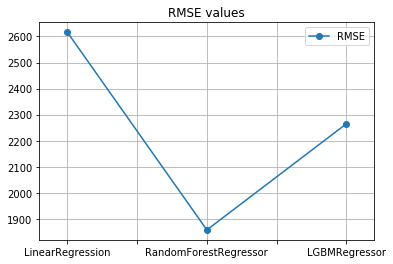

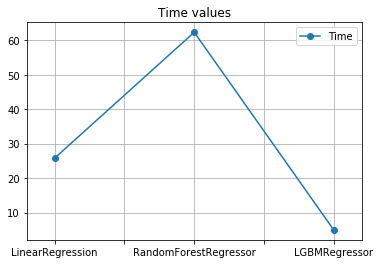

In [16]:
# построим графики показателей качества и времени
models_quality['RMSE'].plot(style='o-', xlim=(-0.2, 2.2), legend=True, grid=True)
plt.title('RMSE values')
plt.show()
models_quality['Time'].plot(style='o-', xlim=(-0.2, 2.2), legend=True, grid=True)
plt.title('Time values')
plt.show()

## Вывод:

получили следующие результаты:

- лучшее время с большим отрывом показала модель LGBMRegressor - 4,64 сек., затем линейная регрессия - 27,2 сек. и модель случайный лес - 1 мин. 4 сек.

- лучшее качество (метрика RMSE) показала модель случайный лес - 1857, далее модель LGBMRegressor - 2264 и худшее показала линейная регрессия - 2616.

Таким образом, модель LGBMRegressor показала среднее качество, но очень высокую скорость.